# tutorial

A. link to helpful python docs

Recapitation, Simplification, and Mutation: https://pyslim.readthedocs.io/en/latest/tutorial.html#recapitation-simplification-and-mutation

Saving Individuals in .trees file: https://pyslim.readthedocs.io/en/latest/tutorial.html#obtaining-and-saving-individuals

Some Basic Plotting:
https://www.geeksforgeeks.org/graph-plotting-in-python-set-1/
(Esther's note: I'm not sure if this site is reliable but it helped me, so feel free to remove!)

B. Which packages you need and what they do and link to docs

What is pyslim + how to install: https://pypi.org/project/pyslim/

What is tskit: https://tskit.dev/tskit/docs/stable/introduction.html
    + Install tskit: https://tskit.dev/tskit/docs/stable/installation.html

What is NumPy, install, import: https://numpy.org/doc/stable/user/absolute_beginners.html

What is Msprime: https://tskit.dev/msprime/docs/stable/quickstart.html
    + Install Msprime: https://tskit.dev/msprime/docs/stable/installation.html#sec-installation

Install IPython: https://ipython.org/install.html
	(SVG from IPython.display allows us to display trees in SVG format)
    
What is Matplotlib: https://matplotlib.org/stable/index.html
    + Install Matplotlib: https://matplotlib.org/stable/users/installing.html
    (We can use things like matplotlib.pyplot as plt for plotting, matplotlib.cm as cm 
    for color maps, and various widgets)

In [1]:
#If we want to be able to rotate 3D plots, we can set up the matplotlib widget tool.
%matplotlib widget
#We can import these packages in our notebooks like this:
import pyslim, tskit
import numpy as np
import msprime
from IPython.display import SVG #for displaying trees in svg format
import matplotlib
import matplotlib.pyplot as plt #plotting
import matplotlib.cm as cm #color maps
#%matplotlib inline

In [2]:
import os #module to run commands on the code line from within python
SLiM = 'slim' #command to run SLiM from your command line

# BASICS

## 0. run a slim sim (Matt)

We first write out our SLiM script as text

In [3]:
SLiM_script = """
initialize() {

   setSeed(1);                                    // set seed for repeatability
   initializeSLiMModelType("nonWF");              // non-Wright-Fisher to allow for local density-dependence and prevent clumping
   initializeSLiMOptions(dimensionality="xy");    // 2 dimensions
   initializeTreeSeq(retainCoalescentOnly=F);     // keep all ancestors that remain in tree sequence
   initializeMutationRate(0.0);                   // we will ignore mutations for now and just deal with the trees
   initializeMutationType("m1", 0.5, "f", 0.0);
   initializeGenomicElementType("g1", m1, 1.0);
   initializeGenomicElement(g1, 0, 999999);       // 1Mb chromosome
   initializeRecombinationRate(1e-8);             // some recombination so we get multiple trees

   // parameter values
   defineConstant("LAMBDA", 4.0); // birth rate
   defineConstant("K", 2.0);      // carrying capacity per unit area
   defineConstant("W", 10);       // width and height of the area
   defineConstant("SIGMA", 0.1);  // interaction and dispersal distance
   
   // spatial interaction for local competition
   initializeInteractionType("i1", "xy", reciprocal=T, maxDistance = 10 * SIGMA);  // interaction for both mate choice and density dependence
   i1.setInteractionFunction("n", 1.0/(2*PI*SIGMA^2), SIGMA);                      // normally distributed around the focal individual with variance SIGMA^2 along both axes
}

reproduction() {
   neighbor_density = i1.totalOfNeighborStrengths(individual);     // strength of competition felt from neighbours
   num_offspring = rpois(1, LAMBDA / (1 + neighbor_density / K));  // number of offspring is Poisson distributed with a mean depending on LAMBDA, neighbor_density, and K
   mate = i1.drawByStrength(individual, 1);                        // single mate drawn randomly weighted by interaction strengths
   if (size(mate) > 0) {                                           // if there is a mate (might not be if no neighbors)
       for (k in seqLen(num_offspring)) {                          // for each offspring
           offspring = p1.addCrossed(individual, mate);            // create by recombination
           pos = individual.spatialPosition + rnorm(2, 0, SIGMA);  // position of offspring is normally distributed around "mother" with variance SIGMA in both axes
           offspring.setSpatialPosition(p1.pointReflected(pos));   // reflecting boundaries
       }
   }
}

1 early() {
   
   
   sim.addSubpop("p1", 2);  //start with just two ancestors (helps make everyone coalesce in a short time)                     

   p1.setSpatialBounds(c(0.0, 0.0, W, W)); // set spatial bounds (square with width W)
   
   // start ancestors in 1x1 square in the center of range
   p1.individuals.x = runif(p1.individualCount) + (W-1)/2; 
   p1.individuals.y = runif(p1.individualCount) + (W-1)/2;
}

early() { 
    p1.fitnessScaling = 1;                   // density dependence occurs in fecundity
    inds = sim.subpopulations.individuals;
    inds[inds.age > 0].fitnessScaling = 0.0; // enforce discrete generations
}

late() {
   i1.evaluate(); //evaluate interaction strengths for next generation
}

late() {
   sim.treeSeqRememberIndividuals(p1.individuals, permanent=F); // retain individuals remaining in the tree sequence
}

1000 late() { 
   sim.treeSeqOutput("spatial_sim.trees"); //save the tree sequence
   catn("Done.");
   sim.simulationFinished();
}

"""

now we run this from the command line (should get a "0" if it worked)

In [4]:
os.system("echo '" + SLiM_script + "' | " + SLiM) #we "echo" the text above and "pipe" it to SLiM

0

## 1. load and simplify tree sequence to a sample (Nadine)

just writing a very brief version here in the meantime, Nadine, so we can work on the sections below, but go ahead and update and annotate this as you like

In [5]:
ts = pyslim.load('spatial_sim.trees') #load tree sequence
np.random.seed(1); n = 5; sampled_nodes = np.random.choice(ts.samples(), 5, replace=False) #take sample of n nodes without replacement (set seed for repeatability)
sts = ts.simplify(sampled_nodes, keep_unary=True) #simplify but keep unary nodes & individuals
# SVG(sts.draw_svg()) #draw if you wish (but kind of ugly with all the unary nodes)
sts #print some summaries of the simplified tree sequence

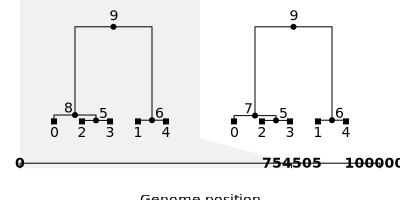

In [6]:
# draw the tree sequence without the unary nodes if you'd like! (there will likely be many fewer trees)
SVG(sts.simplify(keep_unary=False).draw_svg())

## 2. locate children and parents (Pam)

### traversing up a tree

In [7]:
tree0 = sts.at_index(0)

print (tree0)

from IPython.display import SVG
SVG(tree0.draw_svg())

╔═══════════════════════════════════╗
║Tree                               ║
╠═══════════════════╤═══════════════╣
║Index              │              0║
╟───────────────────┼───────────────╢
║Interval           │0-26539 (26539)║
╟───────────────────┼───────────────╢
║Roots              │              1║
╟───────────────────┼───────────────╢
║Nodes              │           2575║
╟───────────────────┼───────────────╢
║Sites              │              0║
╟───────────────────┼───────────────╢
║Mutations          │              0║
╟───────────────────┼───────────────╢
║Total Branch Length│           2035║
╚═══════════════════╧═══════════════╝



In [8]:
tree0.nodes

<bound method Tree.nodes of <tskit.trees.Tree object at 0x7fbea32e78e0>>

In [9]:
samps = tree0.samples() #retrieve all samples in the tree

nodes = []

for i in samps:
    
    samp_ind = sts.node(i).id #find the node id of the sample in question
    nodes.append(samp_ind) #add it to the list of nodes
    nodes.append(tree0.parent(i))

print(nodes)

inds = []

for i in nodes:
    ind = sts.node(i).individual #find the individual this sample node is in
    inds.append(ind) #add it to the list of individuals
    
print (inds)
len(inds)

[1, 8, 4, 9, 3, 7, 2, 6, 0, 5]
[3, 2515, 4, 2516, 2, 2514, 1, 2513, 0, 2512]


10

In [10]:
sts.individual(2)

Individual(id=2, flags=327680, location=array([3.97982712, 7.14286006, 0.        ]), parents=array([], dtype=int32), nodes=array([3], dtype=int32), metadata={'pedigree_id': 139956, 'age': 0, 'subpopulation': 1, 'sex': -1, 'flags': 0})

In [11]:
samps = tree0.samples() #retrieve all samples in the tree
root_t = sts.node(tree0.root).time #find how many generations ago the root existed

nodes = []
inds = []
times = []

for i in samps:
    samp_ind = sts.node(i).id #find the node id of the sample in question
    nodes.append(samp_ind) #add it to the list of nodes
    
    parent = tree0.parent(i) #find the parent node of the sample node in question
    nodes.append(parent) #add it to the list of nodes
    
    ind = sts.individual(sts.node(parent).individual) #find the individual that parent node is in
    inds.append(ind) #add it to the list of individuals
    
    t = sts.node(parent).time #find how many generations ago the parent existed
    times.append(t) #add it to the list of times
    
    #Now we want to find the parent of the parent
    
    while t < root_t: #Ensure we find parents of parents until we hit the root
        parent = tree0.parent(parent) #overwrite the parent variable to its parent
        nodes.append(parent) #add it to the list of nodes
        t = sts.node(parent).time #overwrite the t variable to the time of the parent's parent
        
#print (nodes) #Check that the code worked

In [12]:
samps = tree0.samples() #retrieve all samples in the tree sequence
root_t = sts.node(tree0.root).time #find how many generations ago the root existed

list_of_nodes = []
list_of_inds = []
    
for i in samps:
    
    nodes = []
    inds = []
    
    samp_node = sts.node(i).id #find the node id of the sample in question
    nodes.append(samp_node) #add it to the list of nodes
    ind = sts.node(i).individual #find the individual this sample node is in
    inds.append(ind) #add it to the list of individuals
    
    parent = tree0.parent(i) #find the parent node of the sample node in question
    nodes.append(parent) #add it to the list of nodes
    p_ind = sts.node(parent).individual #find the individual that parent node is in
    inds.append(p_ind) #add it to the list of individuals
    
    t = sts.node(parent).time #find how many generations ago the parent existed
    
    while t < root_t: #Ensure we find parents of parents until we hit the root
        parent = tree0.parent(parent) #overwrite the parent variable to its parent
        nodes.append(parent) #add it to the list of nodes
        p_ind = sts.node(parent).individual #find the individual that parent node is in
        inds.append(p_ind) #add it to the list of individuals
                 
        t = sts.node(parent).time #overwrite the t variable to the time of the parent's parent
        
    list_of_nodes.append(nodes)
    list_of_inds.append(inds)
        
#print (list_of_nodes)
#print (list_of_inds)

### all edges in the tree sequence

I gotta fix this code because it's really slowing down the notebook.

There is a way to ___ the entire tree sequence, using its edges. Each edge connects a 'parent' node and a 'child' node (see 'Edge Table' in the tskit documentation for the details).

In [13]:
#p_ch_nodes = []

#for edge in sts.edges():
 #   p_ch_nodes.append(edge.parent) #we append the parent node for the edge
 #   p_ch_nodes.append(edge.child) #we append the child node for the edge
# now each parent node is followed by its child node



#p_ch_inds = []

#for i in p_ch_nodes:
 #   for node in sts.nodes():
 #       if i == node.id:
#            p_ch_inds.append(node.individual)
# now each parent individual is followed by its child individual

##MIGHT BE EASIER IF WE TAKE A SAMPLE NODE

In [14]:
ts.individual_parents()

array([[2556, 2561],
       [2557, 2561],
       [2713, 2721],
       ...,
       [3619,  163],
       [3620,  162],
       [3620,  164]], dtype=int32)

In [15]:
sts.samples()

array([0, 1, 2, 3, 4], dtype=int32)

In [30]:
## KEEPS INDIVIDUAL INFORMATION

samp_nodes = sts.samples() #retrieve all sample nodes in the tree

#find the individual each node belongs to
samp_inds = []
for i in samp_nodes:
    nod = sts.node(i)
    samp_inds.append(nod.individual) #append to list of sample individuals
    
print (inds)

[Individual(id=0, flags=327680, location=array([1.61635532, 6.07023183, 0.        ]), parents=array([], dtype=int32), nodes=array([0, 1], dtype=int32), metadata={'pedigree_id': 139860, 'age': 0, 'subpopulation': 1, 'sex': -1, 'flags': 0}), Individual(id=1, flags=327680, location=array([1.4558714 , 6.32139402, 0.        ]), parents=array([], dtype=int32), nodes=array([2, 3], dtype=int32), metadata={'pedigree_id': 139861, 'age': 0, 'subpopulation': 1, 'sex': -1, 'flags': 0}), Individual(id=2, flags=327680, location=array([1.4917632 , 6.17272319, 0.        ]), parents=array([], dtype=int32), nodes=array([4, 5], dtype=int32), metadata={'pedigree_id': 139862, 'age': 0, 'subpopulation': 1, 'sex': -1, 'flags': 0}), Individual(id=3, flags=327680, location=array([1.45094551, 6.32535531, 0.        ]), parents=array([], dtype=int32), nodes=array([6, 7], dtype=int32), metadata={'pedigree_id': 139863, 'age': 0, 'subpopulation': 1, 'sex': -1, 'flags': 0}), Individual(id=4, flags=327680, location=arr

In [40]:
## KEEPS ONLY INDIVIDUAL ID

samp_nodes = sts.samples()

samp_inds = []

for i in samp_nodes:
    ind = sts.node(i).individual
    samp_inds.append(ind)
    
print(samp_inds)

[0, 3, 1, 2, 4]


In [46]:
samps = sts.samples() #retrieve all sample nodes in the tree

#find the individual each node belongs to
inds = []
for i in samps:
    ind = ts.individual(i).id
    inds.append(ind)
    
print (inds)

[0, 1, 2, 3, 4]


In [48]:
samps = sts.samples() #retrieve all sample nodes in the tree

#find the individual each node belongs to
inds = []
for i in samp_nodes:
    ind = sts.node(i).individual
    inds.append(ind)


p_and_ch = ts.individual_parents() #returns all parent child relationships
print(p_and_k[:,0]) #find the ones we care about

#for i in p_and_k[:,0]:
#    if i == i in samps:
#        print ('yeet')

[2556 2557 2713 2714 2718 2719 2750 2751 2769 2770 2797 2798 2820 2821
 2846 2847 2855 2856 2862 2863 2885 2887 2893 2894 2900 2901 2921 2922
 2931 2932 2967 2970 2988 2989 3020 3020 3021 3022 3031 3033 3052 3053
 3063 3064 3081 3083 3086 3087 3088 3089 3094 3095 3119 3120 3125 3127
 3132 3133 3134 3135 3138 3139 3155 3156 3157 3157 3158 3158 3166 3167
 3168 3171 3175 3176 3179 3180 3191 3192 3199 3200 3202 3203 3203 3204
 3204 3205 3213 3215 3217 3218 3219 3220 3224 3225 3238 3239 3241 3247
 3252 3253 3254 3259 3261 3261 3262 3262 3263 3263 3264 3265 3266 3267
 3272 3274 3276 3277 3278 3281 3282 3284 3285 3288 3290 3292 3293 3294
 3294 3297 3298 3299 3300 3306 3316 3317 3318 3319 3321 3322 3322 3324
 3324 3324 3325 3326 3328 3329 3330 3331 3331 3332 3333 3333 3334 3335
 3335 3336 3337 3337 3338 3338 3339 3343 3343 3345 3345 3347 3347 3347
 3348 3350 3350 3354 3355 3356 3357 3360 3360 3362 3363 3364 3365 3368
 3369 3370 3372 3373 3373 3374 3374 3375 3377 3380 3381 3383 3384 3385
 3386 

# EXTENSIONS

## discrete space / metapopulations (Pam)